In [302]:
import torch
import os
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
import cv2
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader
from torchsummary import summary
from tqdm import tqdm
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
torch.cuda.empty_cache()

In [303]:
# data_path = "D:\MInf\Datasets\Celeb-DF-v2-OC\Celeb-rnd-30-OC-real-train".replace("\\", "/")
data_path = "D:/MInf/Datasets/DariusAf_Deepfake_Database-OC/real-train/"
current_subpath = ""
for subpath in data_path.split("/")[:-1]:
    current_subpath += f"{subpath}/"
    print(f"{os.listdir(current_subpath)}\n")

['$RECYCLE.BIN', '.Trash-1000', 'Config.Msi', 'GOG Games', 'MInf', 'OneDriveTemp', 'Program Files', 'Program Files (x86)', 'Riot Games', 'System Volume Information', 'TDDS-G35-CW3', 'Users', 'WindowsApps', 'WpSystem', 'WUDownloadCache']

['Comparing-the-Performance-of-Deepfake-Detection-Methods-on-Benchmark-Datasets-master', 'DariusAf_MesoNet', 'Datasets', 'Kiteco_Deepfake_Detection', 'MInf-DeepfakeDetection-FrameDifferencing', 'MLP-DeepfakeDetection-VariationalAutoencoder', '_BASELINE_TESTS', '_TRAINING']

['Celeb-DF-v2', 'Celeb-DF-v2-OC', 'DariusAf_Deepfake_Database', 'DariusAf_Deepfake_Database-OC', 'FaceForensicspp']

['real-train', 'realfake-test']

['real']



In [304]:
batch_size = 64
epochs = 20
train_root = data_path
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [305]:
transform_train = transforms.Compose([
    transforms.Resize((100,100)),
    transforms.RandomHorizontalFlip(),
    # transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

transform_test = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((100,100)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

In [306]:
class vae(nn.Module):
    def __init__(self):
        super(vae, self).__init__()

        self.conv1 = nn.Conv2d(3, 16, kernel_size=3,stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3,stride=2, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3,stride=1, padding=1, bias=False)
        self.bn3 = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(64, 32, kernel_size=3,stride=2, padding=1, bias=False)
        self.bn4 = nn.BatchNorm2d(32)

        self.fc1 = nn.Linear(25 * 25 * 32, 1000)
        self.fc1_bn = nn.BatchNorm1d(1000)
        self.fc2_mean = nn.Linear(1000, 100)
        self.fc2_logvar = nn.Linear(1000, 100)

        self.fc3 = nn.Linear(100, 1000)
        self.fc3_bn = nn.BatchNorm1d(1000)
        self.fc4 = nn.Linear(1000, 25 * 25 * 32)
        self.fc4_bn = nn.BatchNorm1d(25 * 25 * 32)

        self.relu = nn.ReLU()

        self.conv5 = nn.ConvTranspose2d(32, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn5 = nn.BatchNorm2d(64)
        self.conv6 = nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1, bias=False)
        self.bn6 = nn.BatchNorm2d(32)
        self.conv7 = nn.ConvTranspose2d(32, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn7 = nn.BatchNorm2d(16)
        self.conv8 = nn.ConvTranspose2d(16, 3, kernel_size=3, stride=2, padding=1, output_padding=1, bias=False)
        
    def encode(self, data):
        conv1 = self.relu(self.bn1(self.conv1(data)))
        conv2 = self.relu(self.bn2(self.conv2(conv1)))
        conv3 = self.relu(self.bn3(self.conv3(conv2)))
        conv4 = self.relu(self.bn4(self.conv4(conv3)))

        fc1 = self.relu(self.fc1_bn(self.fc1(conv4.view(-1, 25 * 25 * 32))))
        mean = self.fc2_mean(fc1)
        logvar = self.fc2_logvar(fc1)
        return mean, logvar
    
    def reparameterize(self, mean, logvar):
        std = 0.5 * torch.exp(logvar)
        z = (std.data.new(std.size()).normal_()) * std + mean
        return z
    
    def decode(self, z):
        fc3 = self.relu(self.fc3_bn(self.fc3(z)))
        fc4 = self.relu(self.fc4_bn(self.fc4(fc3)))
        conv5 = self.relu(self.bn5(self.conv5(fc4.view(-1, 32, 25, 25))))
        conv6 = self.relu(self.bn6(self.conv6(conv5)))
        conv7 = self.relu(self.bn7(self.conv7(conv6)))
        conv8 = self.conv8(conv7)
        return conv8.view(-1, 3, 100, 100)
    
    def forward(self, x):
        mean, logvar = self.encode(x)
        z = self.reparameterize(mean, logvar)
        return self.decode(z), mean, logvar

def loss_function(recon_x, x, mean, logvar):
    mse_loss = nn.MSELoss(reduction="sum")
    reconstruction_loss = mse_loss(recon_x, x)
    kld_loss = -0.5 * torch.sum(1+logvar-torch.exp(logvar)-mean**2)
    return reconstruction_loss + kld_loss

In [307]:
train_loader = torch.utils.data.DataLoader(
    datasets.ImageFolder(train_root, 
                         transform=transform_train),
                         batch_size=batch_size, 
                         shuffle=True,
                         drop_last = True)
fakedect = vae().to(device)
optimizer = optim.Adam(fakedect.parameters(), lr=5e-4)
print(summary(fakedect, (3, 100, 100)))

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 16, 100, 100]        432
├─BatchNorm2d: 1-2                       [-1, 16, 100, 100]        32
├─ReLU: 1-3                              [-1, 16, 100, 100]        --
├─Conv2d: 1-4                            [-1, 32, 50, 50]          4,608
├─BatchNorm2d: 1-5                       [-1, 32, 50, 50]          64
├─ReLU: 1-6                              [-1, 32, 50, 50]          --
├─Conv2d: 1-7                            [-1, 64, 50, 50]          18,432
├─BatchNorm2d: 1-8                       [-1, 64, 50, 50]          128
├─ReLU: 1-9                              [-1, 64, 50, 50]          --
├─Conv2d: 1-10                           [-1, 32, 25, 25]          18,432
├─BatchNorm2d: 1-11                      [-1, 32, 25, 25]          64
├─ReLU: 1-12                             [-1, 32, 25, 25]          --
├─Linear: 1-13                           [-1, 1000]                20,00

In [308]:

weights_path = "D:/MInf/_TRAINING/OC-FakeDect-Implementation/OC_FD_e22_l1401.pkl"
fakedect = torch.load(weights_path)

min_loss = float("inf")
for epoch in range(3):
    fakedect.train()
    train_loss = 0
    for batch_idx, (inputs, _) in enumerate(train_loader):
        train_loss = 0
        for i in range(100):
            inputs = inputs.to(device)
            gen_imgs, mean, logvar = fakedect(inputs)
            loss = loss_function(gen_imgs, inputs, mean, logvar)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        L = train_loss / len(train_loader.dataset)
        print(f"{epoch=}\tloss={L:.4f}")
    # if L < min_loss:
    #     min_loss = L
    #     torch.save(fakedect, f"OC_FD_e{epoch+1}_l{int(L)}.pkl")
    # print('Epoch: {}  loss: {:.4f}'.format(
    #     epoch, ))

epoch=0	loss=1340.2490
epoch=0	loss=1252.3209
epoch=0	loss=1111.9975
epoch=0	loss=1197.1976
epoch=0	loss=1144.8364
epoch=0	loss=1206.5239
epoch=0	loss=1294.3717
epoch=0	loss=1369.9961
epoch=0	loss=1100.8050
epoch=0	loss=1458.3290
epoch=0	loss=1266.1847
epoch=0	loss=1128.0562
epoch=0	loss=1218.1675
epoch=0	loss=1366.3992
epoch=0	loss=1149.6869
epoch=0	loss=1236.7326
epoch=0	loss=1242.5061
epoch=0	loss=1306.3407
epoch=0	loss=1240.8061
epoch=0	loss=1282.9186
epoch=0	loss=1202.6139
epoch=0	loss=1252.2254
epoch=0	loss=1247.6032
epoch=0	loss=1241.6261
epoch=0	loss=1432.3474
epoch=0	loss=1215.3780
epoch=0	loss=1221.4236
epoch=0	loss=1221.0569
epoch=0	loss=1793.8488
epoch=0	loss=1265.7001
epoch=0	loss=1369.7297
epoch=0	loss=1362.0978
epoch=0	loss=1314.0267
epoch=0	loss=1330.3936
epoch=0	loss=1363.3656
epoch=0	loss=1104.9962
epoch=0	loss=1318.1011
epoch=0	loss=1203.0041
epoch=0	loss=1314.6617
epoch=0	loss=1204.9357
epoch=0	loss=1237.0237
epoch=0	loss=1431.6031
epoch=0	loss=1470.1802
epoch=0	los

KeyboardInterrupt: 

In [ ]:
# # single_batch = 
# for batch_idx, (inputs, _) in enumerate(train_loader):
#     single_batch = inputs.to(device)
#     break

# for epoch in tqdm(range(3000), total=epochs, delay=60):
#     fakedect.train()
#     train_loss = 0
#     # for batch_idx, (inputs, _) in enumerate(train_loader):
#     single_batch = inputs
#     inputs = inputs.to(device)
#     gen_imgs, mean, logvar = fakedect(inputs)
#     loss = loss_function(gen_imgs, inputs, mean, logvar)

#     optimizer.zero_grad()
#     loss.backward()
#     optimizer.step()
#     train_loss += loss.item()
#     L = train_loss / len(train_loader.dataset)
#     print(f"{epoch=}\tloss={L:.4f}")
#     # print('Epoch: {}  loss: {:.4f}'.format(
#     #     epoch, ))


In [ ]:
# single_batch[0].shape

In [ ]:
# from matplotlib import pyplot as plt
# for i in range(5,5+10):
#     test_im = single_batch[i]
#     img = test_im.view(3,100,100).cpu()
#     img = 255*(img*0.5 + 0.5).numpy()
#     img = img.astype(int)
#     # img = (img).numpy()
#     img = np.moveaxis(img, 0, -1)
#     # img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

#     # print(type(img))
#     # print(img.shape)
#     # print(img)
#     # # img = 255*(img*0.5 + 0.5).numpy()
#     # img = np.moveaxis(img, 0, -1)
#     # # img.shape
#     # img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#     # plt.imshow(img)
#     pp = img
#     # plt.show()

#     # # img = 

#     # plt.imshow(img)
#     # img = image.float().to("cpu")
#     with torch.no_grad():
#         image = test_im
#         # print(image.shape)
#         x = image.view(-1,3,100,100)
#         print(x.shape)
#         decode_z, mean_z, logvar_z = fakedect(x)
#         # print(decode_z.shape )
#     decode_z = decode_z.view(3,100,100).cpu()
#     decode_z = 255*(decode_z*0.5 + 0.5).numpy()
#     decode_z = decode_z.astype(int)
#     plt.subplot(1,2,1)
#     # print(np.array(img[::-1].shape))
#     # print(decode_z.transpose(1,2,0).shape)
#     # print(img.shape)
#     plt.imshow(pp)
#     plt.subplot(1,2,2)
#     plt.imshow(decode_z.transpose(1,2,0))
#     plt.show()

In [ ]:
torch.save(fakedect, f"OC_FD_e{epoch+1}_l{int(L)}.pkl")

In [ ]:
# shwcse_img_path = "D:/MInf/Datasets/Celeb-DF-v2-OC/Celeb-rnd-30-OC-realfake-test/Celeb-real/id11_0009_1.png"
# img = cv2.cvtColor(cv2.imread(shwcse_img_path), cv2.COLOR_BGR2RGB)
# image = transform_test(img)
# image = image.float().to(device)
# # print(image.shape)
# # fakedect = torch.load(weights_path)
# fakedect.eval()
# with torch.no_grad():
#     x = image.view(-1,3,100,100)
#     print(x.shape)
#     decode_z, mean_z, logvar_z = fakedect(x)
#     # print(decode_z.shape )
# decode_z = decode_z.view(3,100,100).cpu()
# decode_z = 255*(decode_z*0.5 + 0.5).numpy()
# decode_z = decode_z.astype(int)
# plt.subplot(1,2,1)
# plt.imshow(img)
# plt.subplot(1,2,2)
# plt.imshow(decode_z.transpose(1,2,0))

In [ ]:
test_path = "D:\MInf\Datasets\Celeb-DF-v2-OC\Celeb-rnd-30-OC-realfake-test/".replace("\\", "/")

In [ ]:
# score = {0:[],1:[]}
# for j in os.listdir(test_path):
#     test_img_path = test_path+j+"/"
#     print(test_img_path)
#     image = cv2.cvtColor(cv2.imread(test_img_path), cv2.COLOR_BGR2RGB)
#     image = transform_test(image)
#     image = image.float().to(device)
#     fakedect.eval()
#     with torch.no_grad():
#         reimg = fakedect(image.view(-1,3,100,100))
#         y = fakedect.encode(reimg[0])
#     rsme = ((((reimg[1].cpu() - y[0].cpu())**2).sum()/1024)**0.5).item()
#     if j[len(j) - 5] == 'l':
#         score[1].append(rsme)
#     else:
#         score[0].append(rsme)

In [ ]:
# test_path = "D:/MInf/Datasets/Celeb-DF-v2-OC/Celeb-rnd-30-OC-realfake-test"
test_path =  "D:/MInf/Datasets/DariusAf_Deepfake_Database-OC/realfake-test"
score = {0:[],1:[]}
for class_dir in os.listdir(f"{test_path}/"):
    for test_img in tqdm(os.listdir(f"{test_path}/{class_dir}")):
        # get img
        test_img_path = f"{test_path}/{class_dir}/{test_img}"
        # print(test_img_path)
        if ".png" in test_img_path or ".jpg" in test_img_path or ".jpeg" in test_img_path:
            image = cv2.cvtColor(cv2.imread(test_img_path), cv2.COLOR_BGR2RGB)
            image = transform_test(image)
            image = image.float().to(device)

            fakedect.eval()
            with torch.no_grad():
                x = image.view(-1,3,100,100)
                x_prime, _, _ = fakedect(x)
                z_mean, z_logvar = fakedect.encode(x_prime)
            rsme = ((((mean_z.cpu() - z_mean.cpu())**2).sum()/1024)**0.5).item()
            # print(class_dir)
            if "real" in class_dir:

                score[1].append(rsme)
            else:
                score[0].append(rsme)


100%|██████████| 4260/4260 [00:20<00:00, 204.40it/s]


In [ ]:
np.mean(score[1]), np.var(score[1])
np.mean(score[1]), np.var(score[1])

(0.22703163807913854, 0.0006804116565294591)

In [ ]:
def solve(m1,m2,std1,std2):
  a = 1/(2*std1**2) - 1/(2*std2**2)
  b = m2/(std2**2) - m1/(std1**2)
  c = m1**2 /(2*std1**2) - m2**2 / (2*std2**2) - np.log(std2/std1)
  return np.roots([a,b,c])

intersec = solve(np.mean(score[1]), np.mean(score[0]), np.var(score[1]), np.mean(score[0]))

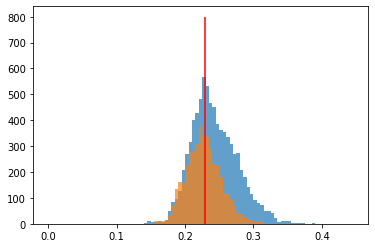

In [ ]:
bins = [x*0.005 for x in range(0, 90)]
plt.hist(score[0],bins,alpha=0.7)[2]
plt.hist(score[1],bins,alpha=0.7)[2]
plt.vlines(x=intersec[0], ymin=0, ymax=800, colors="r")

In [ ]:
real_score = np.array(score[1])
fake_score = np.array(score[0])
threshold = intersec[0]
print('When threshold is {} \nAccuracy of real pics is {}%\n\
Accuracy of fake pics is {:.4f}%\nTotal Accuracy is {:.4f}%\n'.format(
    threshold,\
    100 * ((real_score < threshold).sum() / real_score.shape[0]),\
    100 * ((fake_score > threshold).sum() / fake_score.shape[0]),\
    100 * (((real_score < threshold).sum() + (fake_score > threshold).sum())/(real_score.shape[0] + fake_score.shape[0]))))

When threshold is 0.22936471040855383 
Accuracy of real pics is 56.11645926273773%
Accuracy of fake pics is 61.9904%
Total Accuracy is 59.9410%

